# 数据集成与可视化 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants

from spdm.core.file import File
from spdm.core.function import Function
from spdm.view import sp_view


In [2]:
import fytok

2024-06-06 11:02:12,113 [   fytok]  VERBOSE: Failed to import IMAS ontology:
2024-06-06 11:02:12,115 [   fytok]     INFO: Failed to import IMAS wrapper. Using dummy ontology as fallback.
2024-06-06 11:02:12,121 [   fytok]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU @ Institute of Plasma Physics Chinese Academy of Sciences 
            
 version = 0.5.1  (spdm=0.5.1 )

 Run by salmon at 2024-06-06T11:02:12.113564.
 Job ID: fytok_salmon_surface_9000

###################################################################################################



## 统一数据访问

### 通用资源定位符 URI
```
<local schema>+<protocol>+<format>://<address>/<path>?<query>#<fragment>
```
扩展 protocol
- schema    : 指定数据语义，通常为装置名
- protocol  : 指定数据协议，如 file 或 mdsplus
- format    : 明确指定文件格式

标准语义
- address   : 指定数据地址，如 IP 或主机名
- path      : 指定数据路径
- query     : 指定数据查询条件
- fragment  : 指定数据片段


2024-06-06 11:02:12,178 [   fytok]  VERBOSE: Load module spdm.plugins.data.plugin_xml
2024-06-06 11:02:12,190 [   fytok]  VERBOSE: Load module spdm.view.view_matplotlib


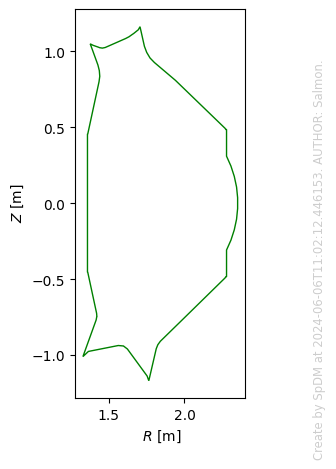

In [3]:
from fytok.modules.wall import Wall

wall = Wall("east://#wall")

fig = sp_view.display(wall)

In [4]:
wall.description_2d[0].vessel.unit[0].annular.outline_outer.r

array([2.844 , 2.8204, 2.7737, 2.7046, 2.6143, 2.5045, 2.3771, 2.2343,
       2.0786, 1.9127, 1.7389, 1.5637, 1.3995, 1.2722, 1.2108, 1.199 ,
       1.199 , 1.199 , 1.199 , 1.199 , 1.199 , 1.199 , 1.199 , 1.199 ,
       1.199 , 1.2108, 1.2722, 1.3995, 1.5637, 1.7389, 1.9127, 2.0786,
       2.2343, 2.3771, 2.5045, 2.6143, 2.7046, 2.7737, 2.8204, 2.844 ])

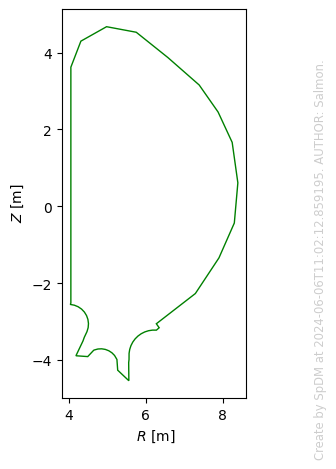

In [5]:
fig = sp_view.display(Wall("iter://#wall"))

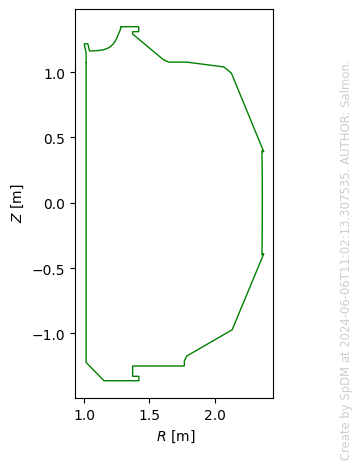

In [6]:
fig = sp_view.display(Wall("d3d://#wall"))

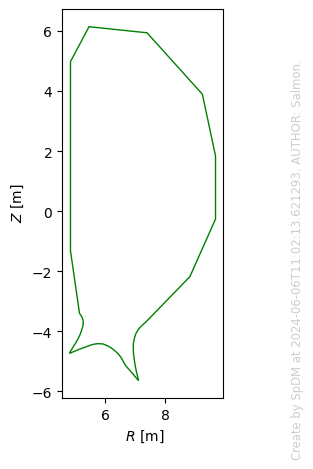

In [7]:
fig = sp_view.display(Wall("cfetr://#wall"))

## 文件访问

In [8]:
eqdsk_file=File(f"file+geqdsk://./data/geqdsk.txt#equilibrium").entry

2024-06-06 11:02:13,806 [   fytok]  VERBOSE: Load module spdm.plugins.data.plugin_geqdsk


In [9]:
psi_norm=eqdsk_file.get("equilibrium/time_slice/0/profiles_1d/psi_norm")
f_value=eqdsk_file.get("equilibrium/time_slice/0/profiles_1d/f")

In [10]:
f_value

array([-33.8061003, -33.800921 , -33.7966702, -33.7930836, -33.7899645,
       -33.7871411, -33.7844635, -33.781825 , -33.7791451, -33.7763632,
       -33.7734438, -33.7703621, -33.7671045, -33.7636626, -33.7600361,
       -33.7562259, -33.7522345, -33.7480646, -33.7437215, -33.7392122,
       -33.7345441, -33.7297256, -33.724765 , -33.7196687, -33.7144402,
       -33.709083 , -33.7036006, -33.6979968, -33.6922752, -33.6864396,
       -33.6804939, -33.6744419, -33.6682864, -33.6620289, -33.6556709,
       -33.6492136, -33.6426577, -33.636004 , -33.6292531, -33.6224064,
       -33.6154658, -33.6084332, -33.6013106, -33.5941002, -33.5868041,
       -33.5794246, -33.5719644, -33.5644281, -33.5568203, -33.549146 ,
       -33.5414097, -33.533616 , -33.5257694, -33.5178745, -33.5099358,
       -33.5019575, -33.4939437, -33.4858987, -33.4778269, -33.469733 ,
       -33.461622 , -33.4534985, -33.4453676, -33.4372345, -33.4291045,
       -33.4209832, -33.4128757, -33.4047858, -33.3967154, -33.3

## 插值函数

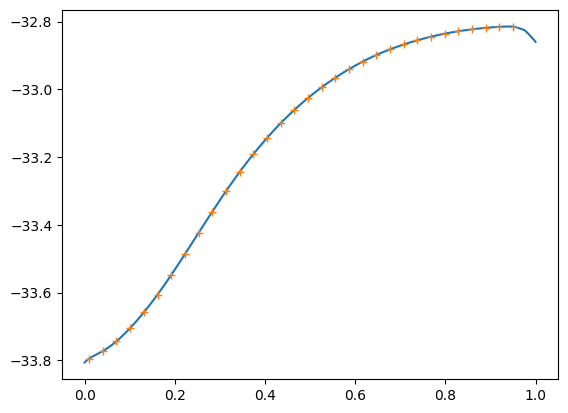

In [11]:
f=Function(psi_norm, f_value)
plt.plot(psi_norm,f_value)
x=np.linspace(0.01,0.95,32)
plt.plot(x,f(x),"+")

## 示例: 平衡分析

In [12]:
astra_profiles = pd.read_excel("./data/profiles.xls",  header=0, usecols="A:BM")

In [13]:
from fytok.modules.equilibrium import Equilibrium

In [14]:
equilibrium = Equilibrium(f"file+geqdsk://./data/geqdsk.txt#equilibrium")

2024-06-06 11:02:15,040 [   fytok]  VERBOSE: Load module fytok.plugins.modules.equilibrium.fy_eq
2024-06-06 11:02:15,151 [   fytok]  VERBOSE: Initialize module fy_eq-0_0_0 


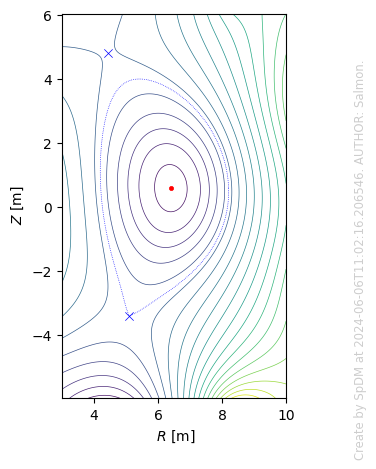

In [15]:
fig=sp_view.display(equilibrium)

In [16]:
eq=equilibrium.time_slice.current
eq_profiles_2d = eq.profiles_2d
eq_profiles_1d = eq.profiles_1d


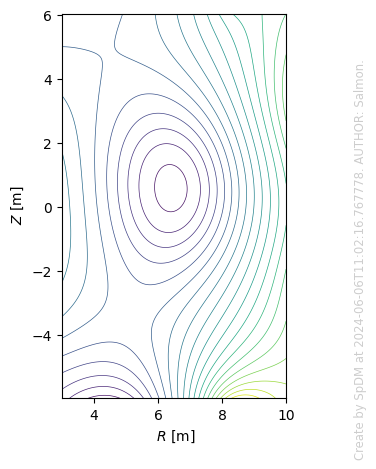

In [17]:
fig = sp_view.display(eq_profiles_2d.psi)

FyTok 会自动将一维数组转换样条插值函数

In [18]:
x = np.linspace(0.01, 0.95, 20)
eq_profiles_1d.f(x)

array([-33.79459354, -33.75534251, -33.69290719, -33.61156839,
       -33.51612325, -33.41379656, -33.31343743, -33.2215806 ,
       -33.14146889, -33.07294172, -33.01538601, -32.96732341,
       -32.92743355, -32.89504316, -32.86987106, -32.85005729,
       -32.83500191, -32.82436855, -32.81738041, -32.8150466 ])

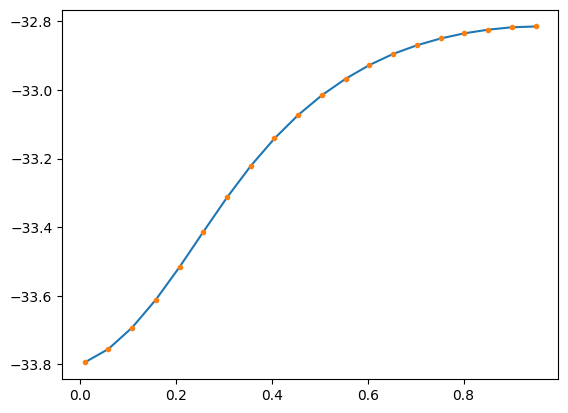

In [19]:
plt.plot(x,f(x))
plt.plot(x,eq_profiles_1d.f(x),".")

2024-06-06 11:02:19,372 [   fytok]  WARNING: /home/salmon/workspace/fytok/python/fytok/plugins/modules/equilibrium/fy_eq/fy_eq.py:234:find_surfaces_by_psi: Can not find surf at -1.1189676199999994  


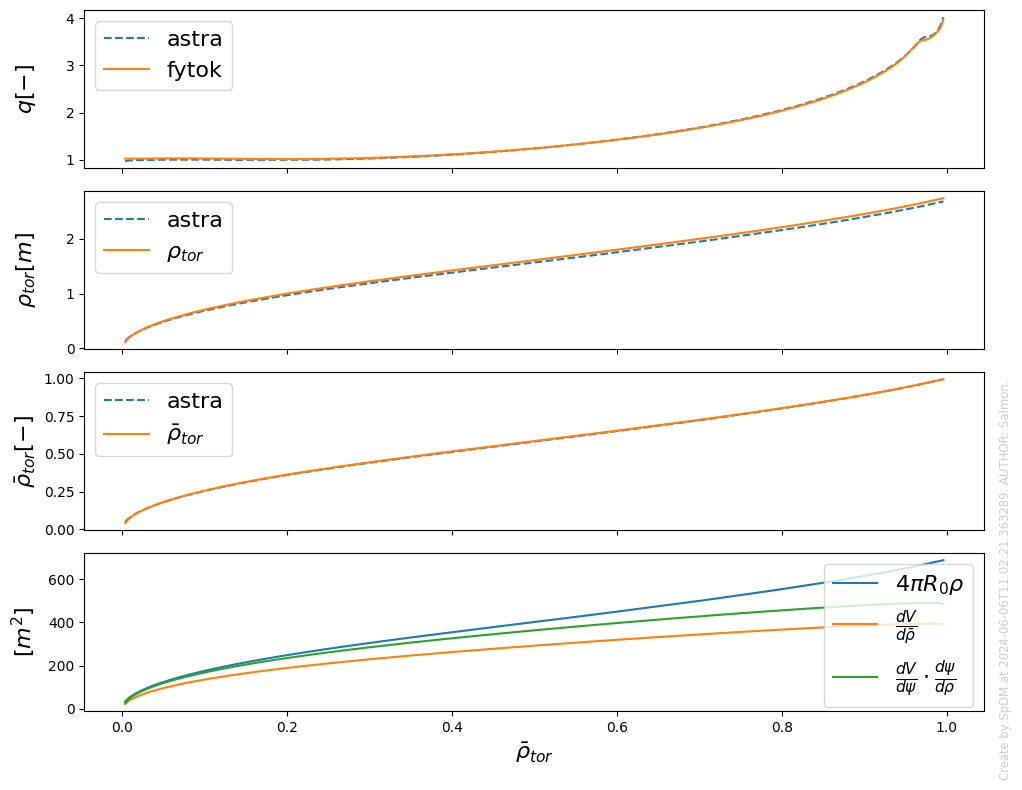

In [20]:
R0 = equilibrium.time_slice.current.vacuum_toroidal_field.r0
psi_axis = equilibrium.time_slice.current.global_quantities.psi_axis
psi_boundary = equilibrium.time_slice.current.global_quantities.psi_boundary
eq_profiles_1d = equilibrium.time_slice.current.profiles_1d

fig = sp_view.plot(
    eq_profiles_1d.psi_norm[1:-1], # 横坐标
    ( # 分组显示
        [
            (
                Function(astra_profiles["xq"].values, astra_profiles["q"].values)(eq_profiles_1d.rho_tor_norm),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.q, {"label": r"fytok"}),
        ],
        {"y_label": r"$q [-]$"},
    ),
    (
        [
            (
                Function(astra_profiles["Fp"].values, astra_profiles["rho"].values),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.rho_tor),
        ],
        {
            "y_label": r"$\rho_{tor}[m]$",
        },
    ),
    (
        [
            (
                Function(astra_profiles["Fp"].values, astra_profiles["x"].values),
                {"label": r"astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
            (eq_profiles_1d.rho_tor_norm),
        ],
        {
            "y_label": r"$\bar{\rho}_{tor}[-]$",
        },
    ),
    (
        [
            Function(
                astra_profiles["Fp"].values,
                4 * (scipy.constants.pi**2) * R0 * astra_profiles["rho"].values,
                label=r"$4\pi R_0 \rho$",
            ),
            (eq_profiles_1d.dvolume_drho_tor, {"label": r"$\frac{dV}{d\bar{\rho}}$"}),
            (
                (scipy.constants.pi * 2.0) * eq_profiles_1d.dvolume_dpsi * eq_profiles_1d.dpsi_drho_tor,
                r"$\frac{dV}{d\psi} \cdot \frac{d\psi}{d\rho}$",
            ),
        ],
        {"y_label": r"$[m^2]$"},
    ),
    x_label=r"$\bar{\rho}_{tor}$",
)

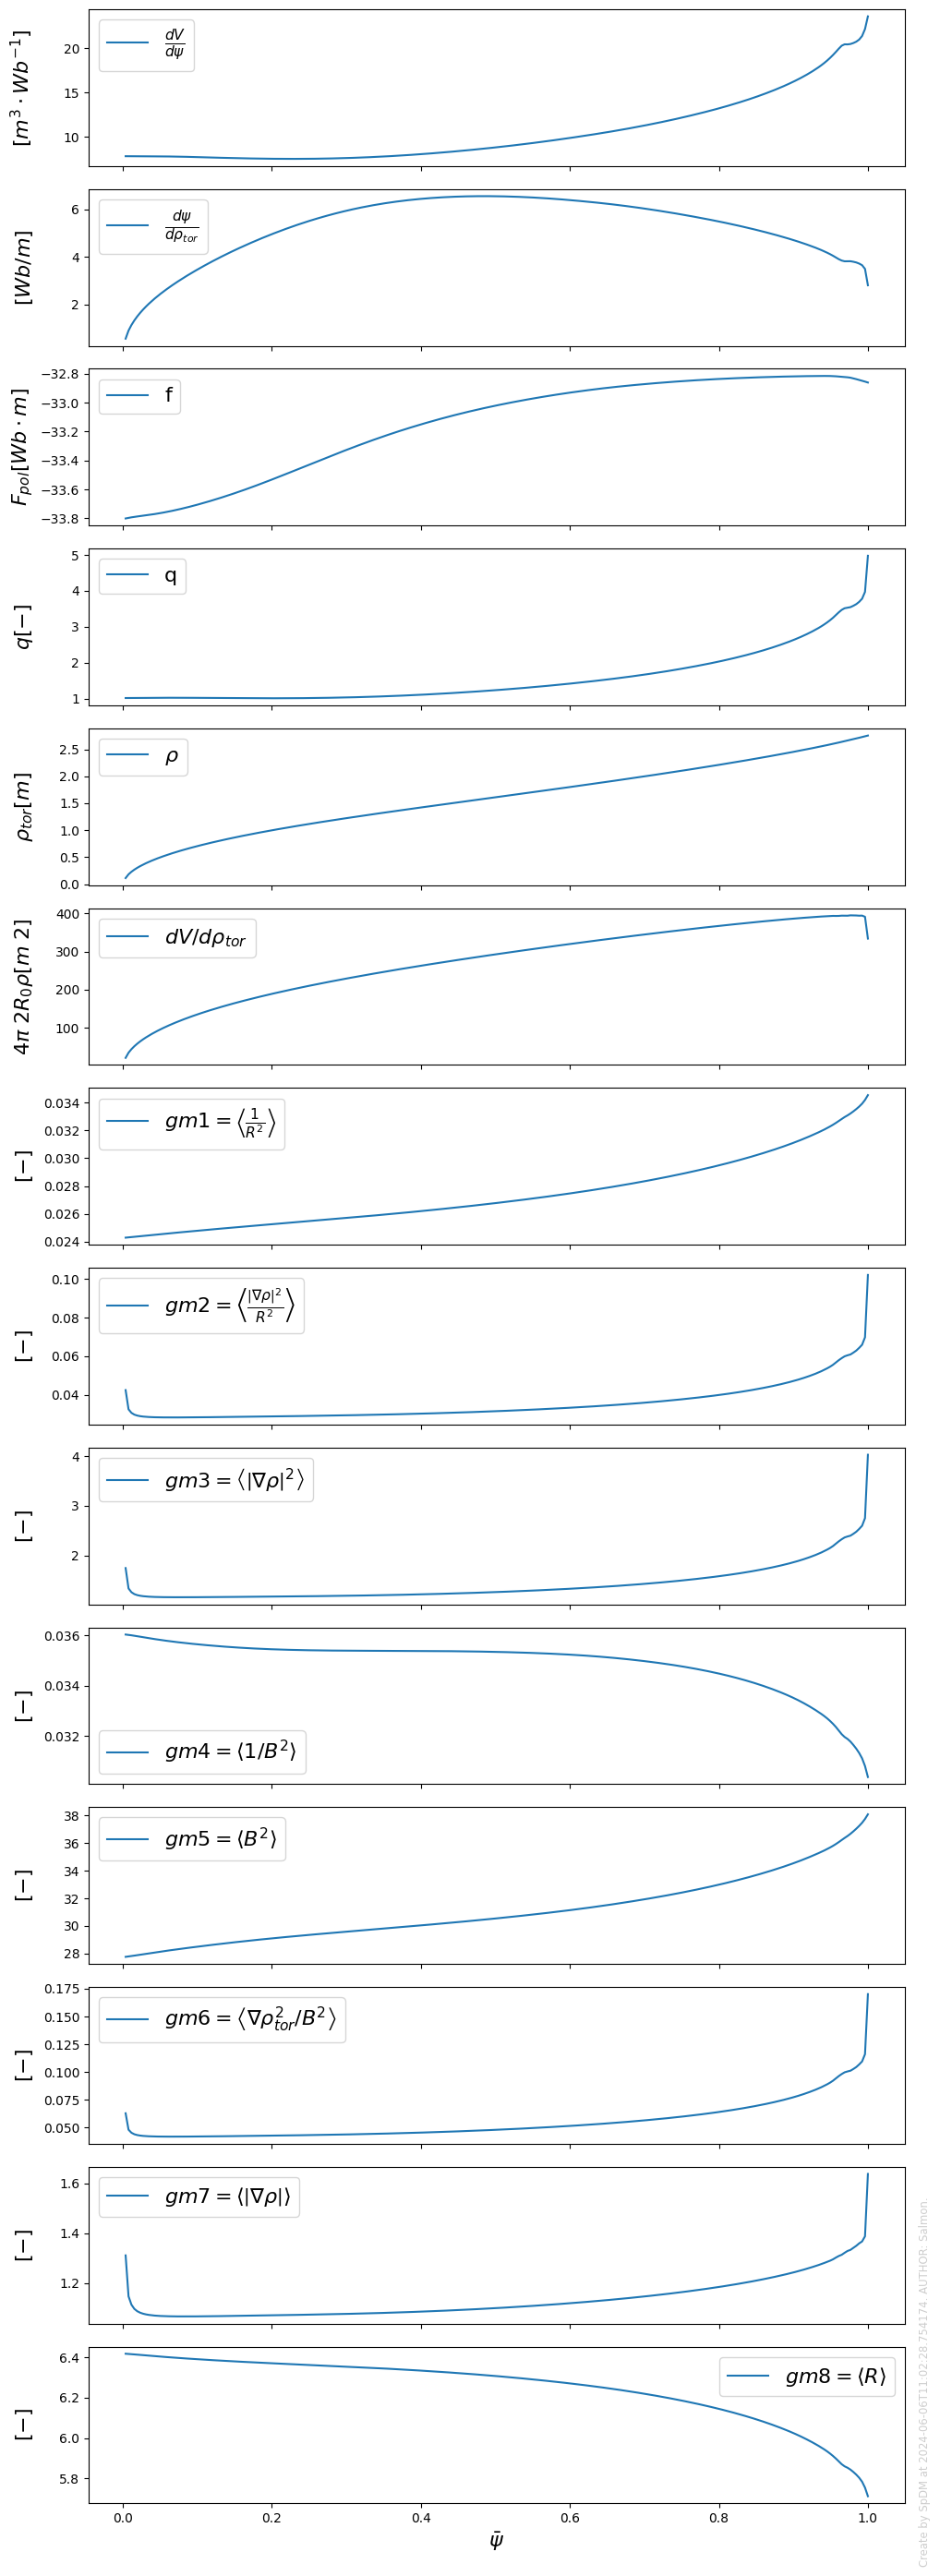

In [21]:
eq_profiles_1d = equilibrium.time_slice.current.profiles_1d
fig = sp_view.plot(  # plot tokamak geometric profile
    eq_profiles_1d.grid.psi_norm[1:],
    (eq_profiles_1d.dvolume_dpsi, r"$\frac{dV}{d\psi}$"),
    (eq_profiles_1d.dpsi_drho_tor, r"$\frac{d\psi}{d\rho_{tor}}$"),
    (eq_profiles_1d.f, {"y_label": r"$F_{pol} [Wb\cdot m]$"}),
    (eq_profiles_1d.q, {"y_label": r"$q [-]$"}),
    ((eq_profiles_1d.rho_tor, r"$\rho$"), {"y_label": r"$\rho_{tor}[m]$"}),
    # ((eq_profiles_1d.rho_tor_norm, r"$\bar{\rho}$"), {"y_label": r"[-]"}),
    ((eq_profiles_1d.dvolume_drho_tor, r"$dV/d\rho_{tor}$"), {"y_label": r"$4\pi ^ 2 R_0 \rho[m ^ 2]$"}),
    (eq_profiles_1d.gm1, r"$gm1=\left<\frac{1}{R^2}\right>$"),
    (eq_profiles_1d.gm2, r"$gm2=\left<\frac{\left|\nabla \rho\right|^2}{R^2}\right>$"),
    (eq_profiles_1d.gm3, r"$gm3=\left<\left|\nabla \rho\right|^2\right>$"),
    (eq_profiles_1d.gm4, r"$gm4=\left<1/B^2\right>$"),
    (eq_profiles_1d.gm5, r"$gm5=\left<B^2\right>$"),
    (eq_profiles_1d.gm6, r"$gm6=\left<\nabla \rho_{tor}^2/ B^2 \right>$"),
    (eq_profiles_1d.gm7, r"$gm7=\left<\left|\nabla \rho\right|\right>$"),
    (eq_profiles_1d.gm8, r"$gm8=\left<R\right>$"),
    x_label=r"\bar{\psi}",
)

# 示例: Tokamak 装置信息

In [22]:
from fytok.tokamak import Tokamak

In [23]:
tokamak = Tokamak(
    device="iter",
    shot=900003,
    equilibrium=f"file+geqdsk://./data/geqdsk.txt#equilibrium",
)

## 展示概要信息

展示模拟的概要信息，包括 
- 装置名称、炮号、运行序号，
- 使用者、运行环境、运行时间、采用的 Ontology 版本
- 调用的模块信心

In [24]:
print(tokamak.brief_summary)

2024-06-06 11:02:31,517 [   fytok]  VERBOSE: Load module fytok.plugins.modules.transport_solver_numerics.fy_trans
2024-06-06 11:02:31,519 [   fytok]  VERBOSE: Initialize module fy_trans-0_0_0 
2024-06-06 11:02:31,608 [   fytok]  VERBOSE: Initialize module fy_eq-0_0_0 
2024-06-06 11:02:31,611 [   fytok]  VERBOSE: Initialize module default-0_0_0 
2024-06-06 11:02:31,615 [   fytok]  VERBOSE: Initialize module default-0_0_0 
2024-06-06 11:02:31,618 [   fytok]  VERBOSE: Initialize module default-0_0_0 

###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU @ Institute of Plasma Physics Chinese Academy of Sciences 
            
 version = 0.5.1  (spdm=0.5.1 )

 Run by salmon at 2024-06-06T11:02:12.113564.
 Job ID: fytok_salmon_surface_9000

####

## 可视化
### 适用于 JupyterLab 环境的可视化接口
FyTok 提供了适用于 JupyterLab 环境的可视化接口，`sp_view.display()`调用。默认情况下，`Tokamak` 会将能够获取到的信息尽可能绘制到一张图上。如下图，展示了 pf_active 极向场线圈、magnetic 磁场探针，wall.limiter 壁, interferometer 干涉仪的几何信息，磁平衡信息给出了二维磁面的等高线，最外层磁面、磁轴、X-point等信息。

```{note} 
具有 IDS 可视化语义的 IDS 都应支持 `sp_view.display()` 可视化，如 wall,pf_active,equilibrium。关于可视化库 spdm.view 的进一步细节请参考第二部分 SpDM 的可视化章节。
```

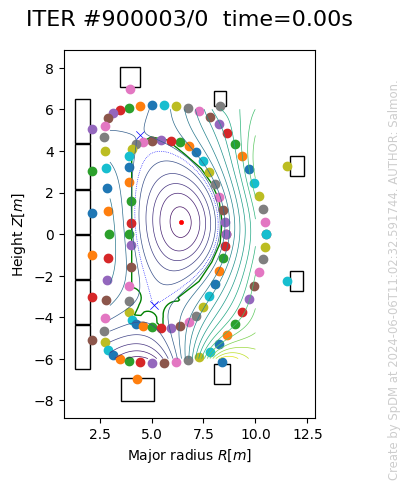

In [25]:
fig=sp_view.display(tokamak)

## 将可视化结果输出为图像文件

通过指定输出文件路径 `output=f"output/{tok.tag}_rz.svg"`，可以将可视化结果以文件的形式保存。

2024-06-06 11:02:33,938 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/view/view_matplotlib.py:95:_figure_post: Write figure to  output/iter_900003_0_000000_rz.svg


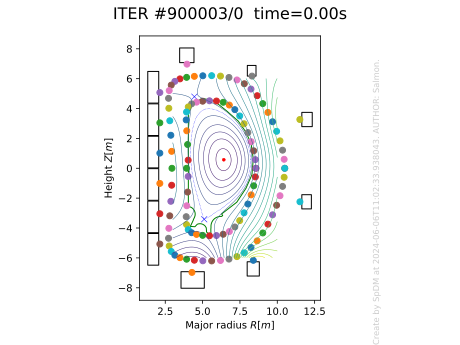

In [26]:
from IPython.core.display import SVG

sp_view.display(tokamak, title=tokamak.title, output=f"output/{tokamak.tag}_rz.svg")

SVG(f"output/{tokamak.tag}_rz.svg")